# Sentiment Analysis

VADER (Valence Aware Dictionary for sEntiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.
It is available in the NLTK package. VADER will not only detect the positiveness/negativess of a word like "love", "like", "enjoy", "hate", but also it is intelligent enough to understand the context of these words such as "did not like" as negative. Also it understands capitalisation and punctuation.

## Loading dependencies

In [1]:
import nltk

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\barto\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
# Example usage
a = "This was the BEST movie ever!"
sid.polarity_scores(a)

{'neg': 0.0, 'neu': 0.489, 'pos': 0.511, 'compound': 0.7371}

### Sentiment Analysis on Bitcoin Posts data

In [4]:
import pandas as pd

input_file = "C:\\Users\\barto\\OneDrive\\Dokumenty\\DS2023Z\\DPRP\\CW3\\dprpy_assignment_3\\data\\bitcoin.stackexchange.com-20240119T151759Z-001\\bitcoin.stackexchange.com\Posts.xml"

In [5]:
df_posts = pd.read_xml(input_file)

In [6]:
def compute_polarity(text: str|None, prefix: str="", suffix: str=""):
    result = {f"{prefix}neg{suffix}": None,
              f"{prefix}neu{suffix}": None,
              f"{prefix}pos{suffix}": None,
              f"{prefix}compound{suffix}": None}
    if pd.isna(text):
        return result
    result_json = {f"{prefix}{key}{suffix}": value for key, value in sid.polarity_scores(text).items()}
    return result_json

In [7]:
import numpy as np

compute_polarity_vec = np.vectorize(compute_polarity)

In [8]:
from tqdm import tqdm
tqdm.pandas(desc="Applying VADER Sentiment Intensity analysis for Title")
df_posts["title_vader"] = df_posts["Title"].progress_apply(compute_polarity_vec, prefix="title_")

Applying VADER Sentiment Intensity analysis for Title:   0%|          | 0/73913 [00:00<?, ?it/s]

Applying VADER Sentiment Intensity analysis for Title: 100%|██████████| 73913/73913 [00:11<00:00, 6447.74it/s]


In [9]:
tqdm.pandas(desc="Applying VADER Sentiment Intensity analysis for Body")
df_posts["body_vader"] = df_posts["Body"].progress_apply(compute_polarity_vec, prefix="body_")

Applying VADER Sentiment Intensity analysis for Body: 100%|██████████| 73913/73913 [03:06<00:00, 397.32it/s]


In [10]:
df_posts = pd.concat([df_posts, 
                      pd.json_normalize(df_posts["title_vader"]),
                      pd.json_normalize(df_posts["body_vader"])], axis=1)
df_posts = df_posts.drop(columns=["title_vader", "body_vader"])

In [11]:
df_posts[["Id", "Title", "Body","title_neg","title_neu", "title_pos", "title_compound",
          "body_neg", "body_neu", "body_pos", "body_compound"]].head(5)

,Id,Title,Body,title_neg,title_neu,title_pos,title_compound,body_neg,body_neu,body_pos,body_compound
0,1,What open source miner applications are there?,<p>What open source miner applications are the...,0.0,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000
1,2,Best GPUs for Mining,"<p>GPU mining is the way to go, as at August 2...",0.0,0.417,0.583,0.6369,0.000,0.797,0.203,0.9432
2,3,Is mining still profitable?,<p>We all know that mining is supposed to keep...,0.0,0.508,0.492,0.4404,0.017,0.926,0.057,0.6007
3,4,None,"<p>The official list is on <a href=""https://en...",NaN,NaN,NaN,NaN,0.000,0.967,0.033,0.6297
4,5,None,"<p><a href=""https://bitcointalk.org/index.php?...",NaN,NaN,NaN,NaN,0.000,0.842,0.158,0.8412


In [19]:
df_posts['CreationDate'] = pd.to_datetime(df_posts['CreationDate'])

# Group by day and sum sentiment scores
daily_sentiment = df_posts.groupby(df_posts['CreationDate'].dt.date).agg({
    'title_pos': 'mean',
    'title_neg': 'mean',
    'title_compound': 'mean',
    'body_pos': 'mean',
    'body_neg': 'mean',
    'body_compound': 'mean'
}).reset_index()

### P

##### Intensity Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


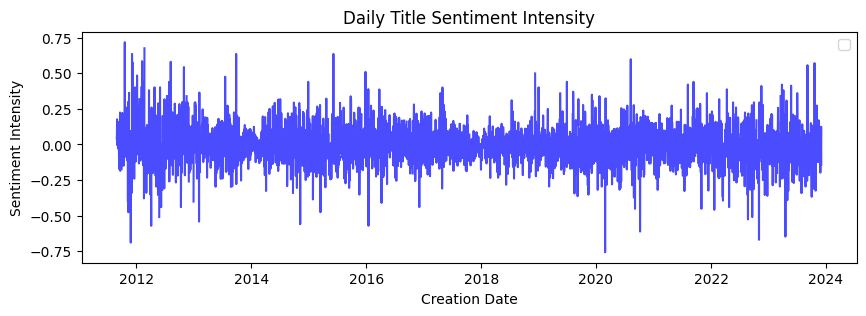

In [23]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_compound'],
         color='blue', alpha=.7)

plt.title('Daily Title Sentiment Intensity')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Intensity')
plt.legend()
plt.show()

##### Positive vs. Negative Sentiment (for Title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


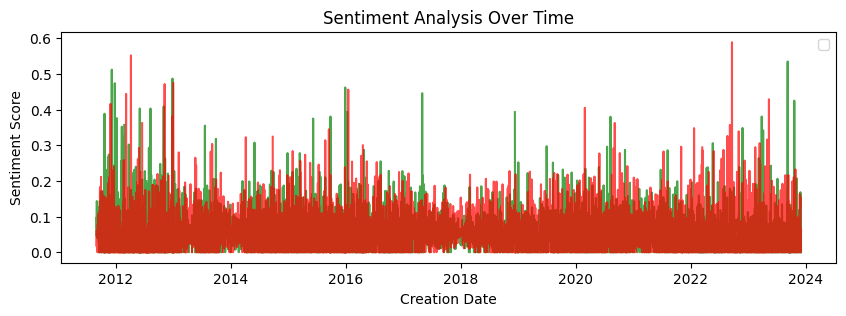

In [24]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_pos'],
         color='green', alpha=.7)
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_neg'],
         color='red', alpha=.7)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

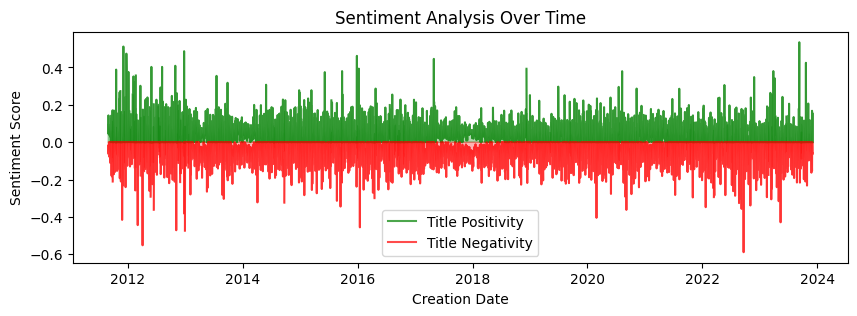

In [21]:
plt.figure(figsize=(10, 3))

# Plot positive sentiment above x-axis
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_pos'], label='Title Positivity',
         color='green', alpha=.7)

# Plot negative sentiment below x-axis
plt.plot(daily_sentiment['CreationDate'], -daily_sentiment['title_neg'], label='Title Negativity',
         color='red', alpha=.7)

# Fill the area between the lines and x-axis
plt.fill_between(daily_sentiment['CreationDate'], daily_sentiment['title_pos'], color='green', alpha=0.3)
plt.fill_between(daily_sentiment['CreationDate'], -daily_sentiment['title_neg'], color='red', alpha=0.3)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

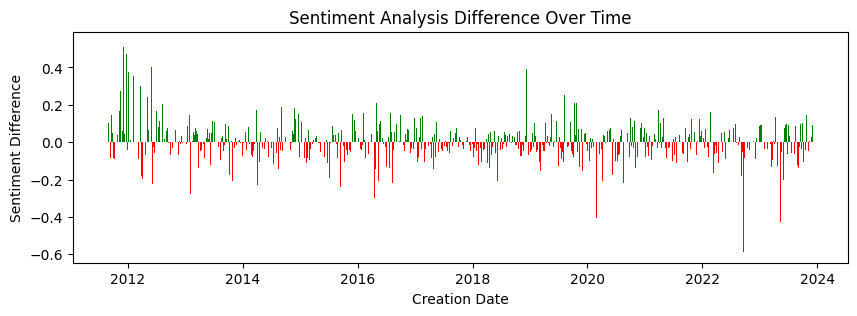

In [26]:
import matplotlib.pyplot as plt

# Calculate the difference between title_pos and title_neg
daily_sentiment['title_difference'] = daily_sentiment['title_pos'] - daily_sentiment['title_neg']

# Plot the bar plot
plt.figure(figsize=(10, 3))
plt.bar(daily_sentiment['CreationDate'], daily_sentiment['title_difference'],
        color=['green' if diff > 0 else 'red' for diff in daily_sentiment['title_difference']])

plt.title('Sentiment Analysis Difference Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Difference')
plt.show()


##### Positive vs. Negative Sentiment (for Body)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


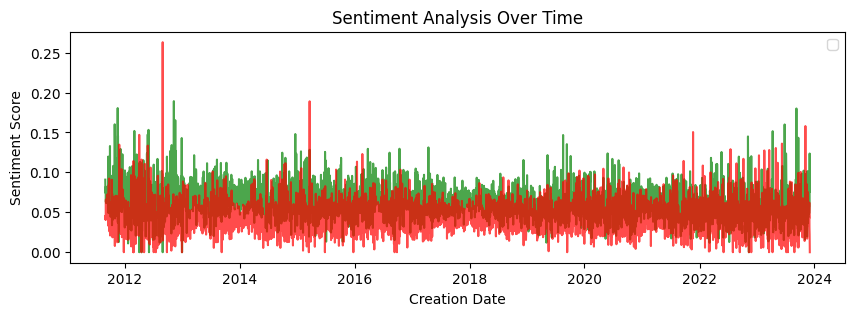

In [27]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['body_pos'],
         color='green', alpha=.7)
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['body_neg'],
         color='red', alpha=.7)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

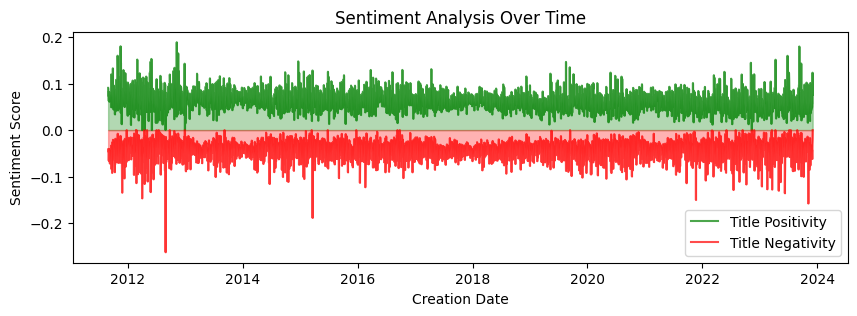

In [28]:
plt.figure(figsize=(10, 3))

# Plot positive sentiment above x-axis
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['body_pos'], label='Title Positivity',
         color='green', alpha=.7)

# Plot negative sentiment below x-axis
plt.plot(daily_sentiment['CreationDate'], -daily_sentiment['body_neg'], label='Title Negativity',
         color='red', alpha=.7)

# Fill the area between the lines and x-axis
plt.fill_between(daily_sentiment['CreationDate'], daily_sentiment['body_pos'], color='green', alpha=0.3)
plt.fill_between(daily_sentiment['CreationDate'], -daily_sentiment['body_neg'], color='red', alpha=0.3)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

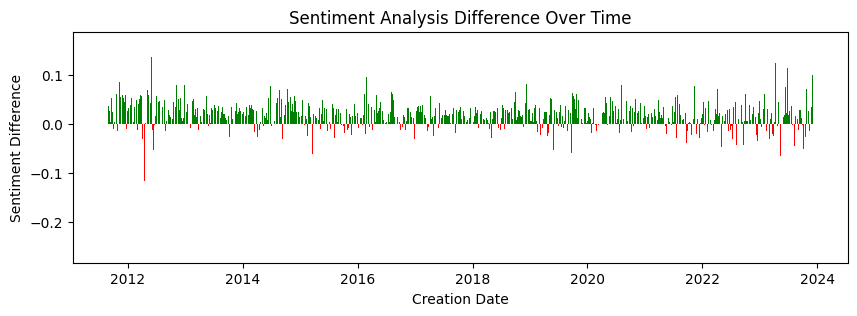

In [29]:
import matplotlib.pyplot as plt

# Calculate the difference between title_pos and title_neg
daily_sentiment['body_difference'] = daily_sentiment['body_pos'] - daily_sentiment['body_neg']

# Plot the bar plot
plt.figure(figsize=(10, 3))
plt.bar(daily_sentiment['CreationDate'], daily_sentiment['body_difference'],
        color=['green' if diff > 0 else 'red' for diff in daily_sentiment['body_difference']])

plt.title('Sentiment Analysis Difference Over Time (Body)')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Difference')
plt.show()
